### **FINM 33165 (Autumn 2023) - Assignment 3**

* Yumeng Zhang (12372205)
* ymzhang@uchicago.edu

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.bernoulli import Bernoulli
from torch.distributions import MultivariateNormal
from torch.distributions.kl import kl_divergence
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
from tqdm import tqdm

import pandas as pd
from sklearn.model_selection import train_test_split

In this assignment, we are going to **train a VAE model to solve a binary classification problem**. Given the credit data, we train the model using samples which are legit (label = 0). After applying the model to test dataset, ideally, the reconstruction loss for fraud samples (label = 1) will be significantly larger than that of legit samples (label = 0). By using a reconstruction error threshold, we could do the classification, and calculate corresponding performance metrics, like the confusion matrix.

#### **1. Load Credit Data**

In [2]:
df_legit = pd.read_csv("credit.csv", index_col=0)

In [3]:
df_legit.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


#### **2. Split Training and Testing Datasets**

In [4]:
X_train, X_test = train_test_split(df_legit, test_size = 0.25)

#### **3. Filter Legitimate Transactions**

In [5]:
X_train = X_train[X_train.Class == 0]
y_train = X_train['Class']

y_test = X_test['Class']

#### **4. Drop Labels in X Dataset**

In [6]:
X_train = X_train.drop(['Class'], axis = 1)
X_test = X_test.drop(['Class'], axis = 1)

In [7]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
6749,0.415451,1.893912,-1.944127,1.873712,0.526844,-1.712611,0.300086,0.289583,0.743477,-1.567025,...,-0.158329,-0.209580,-0.347273,0.181797,0.082094,-0.572238,-0.461808,0.090947,-0.064986,-0.344034
226769,-0.006258,0.746865,0.277592,-0.558277,0.380778,-1.170808,0.955058,-0.170648,0.049651,-0.393661,...,-0.049474,-0.258599,-0.623641,0.104091,0.021651,-0.506052,0.139599,0.238929,0.097779,-0.314648
71452,1.030556,-0.539856,0.505794,0.135031,-0.793349,-0.203007,-0.328288,0.065033,0.435986,-0.110642,...,0.141054,0.018201,-0.094895,-0.135941,0.091085,0.231622,1.006325,-0.083413,0.012443,0.086560
275449,-1.754009,0.682558,1.148168,3.448150,2.553620,5.913386,-1.817342,-1.481688,-1.691771,1.186858,...,0.732334,-1.339317,0.557907,0.524399,0.656489,-0.026326,0.359157,-0.259097,0.038970,-0.277346
232739,1.756646,-2.018198,-0.828720,-2.472675,-1.789387,-0.888104,-0.874121,-0.112300,1.469701,-0.427157,...,-0.235643,0.060336,0.549295,-0.059012,0.087646,-0.093724,-0.711155,0.066667,-0.010877,0.440791


In [8]:
from sklearn.preprocessing import MinMaxScaler

X_train_normalized = X_train.copy()

scaler = MinMaxScaler()
X_train_normalized[X_train.columns] = scaler.fit_transform(X_train_normalized[X_train.columns])

In [9]:
X_train_normalized.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
6749,0.954049,0.793202,0.803725,0.332547,0.772918,0.225046,0.210463,0.799625,0.321406,0.342306,...,0.578580,0.602675,0.493831,0.668133,0.393296,0.594098,0.350013,0.418190,0.486858,0.000090
226769,0.944547,0.779256,0.842224,0.224343,0.771930,0.230643,0.214762,0.794618,0.289704,0.372794,...,0.579739,0.601821,0.480938,0.666979,0.385152,0.598142,0.448252,0.420921,0.492016,0.000376
71452,0.967908,0.763611,0.846178,0.255190,0.763988,0.240642,0.206339,0.797182,0.307356,0.380148,...,0.581767,0.606640,0.505604,0.663415,0.394508,0.643215,0.589830,0.414971,0.489312,0.004282
275449,0.905169,0.778474,0.857310,0.402597,0.786627,0.303829,0.196565,0.780356,0.210135,0.413861,...,0.588063,0.583008,0.536057,0.673221,0.470696,0.627454,0.484116,0.411729,0.490152,0.000739
232739,0.984267,0.745637,0.823053,0.139168,0.757251,0.233564,0.202756,0.795253,0.354589,0.371924,...,0.577756,0.607373,0.535656,0.664557,0.394044,0.623336,0.309282,0.417741,0.488573,0.007730


#### **5. Turn the Datasets into Tensors**

In [10]:
X_train = torch.from_numpy(X_train.values).to(torch.float)
X_train_normalized = torch.from_numpy(X_train_normalized.values).to(torch.float)

y_train = torch.from_numpy(y_train.values).to(torch.float)

X_test = torch.from_numpy(X_test.values).to(torch.float)

#### **6. Encoder Class**

In [11]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):

        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)        
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        
        self.mean_layer = nn.Linear(latent_dim, 2)     
        self.logvar_layer = nn.Linear(latent_dim, 2)     
        
    def forward(self,x):
        
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        logvar = F.softplus(logvar) 
        
        return mean, logvar

In [12]:
encoder = Encoder(input_dim = 29, hidden_dim = 15, latent_dim = 8)

x_sample = X_train[0]
print(x_sample)

tensor([ 0.4155,  1.8939, -1.9441,  1.8737,  0.5268, -1.7126,  0.3001,  0.2896,
         0.7435, -1.5670,  3.1209, -3.1095, -0.2475, -1.2405, -0.2292,  1.1441,
         3.6430,  2.4553, -0.3966, -0.1583, -0.2096, -0.3473,  0.1818,  0.0821,
        -0.5722, -0.4618,  0.0909, -0.0650, -0.3440])


In [13]:
mean, logvar = encoder.forward(x_sample)

print("mean vector: ", mean.view(-1).tolist())
print("log variance vector: ", logvar.view(-1).tolist())

mean vector:  [-0.2013084441423416, 0.06428743898868561]
log variance vector:  [0.7849966883659363, 0.5111600756645203]


#### **7. Decoder Class**

In [14]:
def reparametrize(mean, var):

    epsilon = torch.randn_like(var)
    z = mean + torch.sqrt(var) * epsilon
    
    return z


class Decoder(nn.Module):
    
    def __init__(self, latent_dim = 8, hidden_dim = 15, input_dim = 29):

        super().__init__()
        
        self.fc1 = nn.Linear(2, latent_dim)    
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, u):
        
        u = self.fc1(u)
        u = F.relu(u)  

        u = self.fc2(u)
        u = F.relu(u)

        u = self.fc3(u)
        
        # z = F.sigmoid(u).to(torch.float)
        z = u.to(torch.float)  
        
        return z

In [15]:
z_sample = reparametrize(mean, torch.exp(logvar))

decoder = Decoder(input_dim = 29, hidden_dim = 15, latent_dim = 8)
x_sample_reconstruct = decoder.forward(z_sample)

In [16]:
print(x_sample_reconstruct)

tensor([ 0.0995, -0.2112,  0.0650, -0.0673,  0.0884,  0.2616,  0.3403,  0.0065,
         0.3810,  0.2637,  0.0931, -0.0286, -0.0386, -0.1354,  0.0126,  0.0516,
         0.0986,  0.3364, -0.3621,  0.3898,  0.3840, -0.0400, -0.0510,  0.2308,
         0.0845, -0.1508,  0.1336, -0.0802, -0.1857], grad_fn=<ViewBackward0>)


#### **8. VAE Class**

In [17]:
class VAE(nn.Module):
    
    def __init__(self, input_dim = 784, hidden_dim = 400, latent_dim = 200):

        super().__init__()
        
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        
    def reparametrize(self, mean, var):

        epsilon = torch.randn_like(var)
        z = mean + torch.sqrt(var) * epsilon

        return z
    
    def forward(self, x):
        
        mean, logvar = self.encoder(x)
        
        u = self.reparametrize(mean, torch.exp(logvar))
        z = self.decoder(u)
        
        return z, mean, logvar    


def loss_function(x, z, mean, logvar):

    # reconstruction_loss = F.binary_cross_entropy(z, x, reduction='sum')
    reconstruction_loss = F.mse_loss(z, x, reduction='sum')
    KL_div =  - 0.5 * torch.sum(1+ logvar - mean**2 - torch.exp(logvar))
    
    return reconstruction_loss + KL_div    

#### **9. Training**

In [18]:
X_train_dataset = TensorDataset(X_train, y_train)
X_train_normalized_dataset = TensorDataset(X_train_normalized, y_train)

In [19]:
X_train_dataloader = DataLoader(X_train_dataset, batch_size = 64, shuffle = True)
X_train_normalized_dataloader = DataLoader(X_train_normalized_dataset, batch_size = 64, shuffle = True)

In [20]:
def training(model, train_loader, lr, epochs):

    optimizer = Adam(vae.parameters(), lr = lr)
    average_loss_list = []

    batch_size = 64

    for e in tqdm(range(epochs)):

        overall_loss = 0.0

        for i,x in enumerate(train_loader):
            
            x = x[0]
            
            z,mean,logvar = vae(x)
            
            optimizer.zero_grad()

            loss = loss_function(x, z, mean,logvar)
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        # print("\tEpoch", e + 1, "\tAverage Loss: ", overall_loss/(i*batch_size))
        average_loss_list.append(overall_loss/(i*batch_size))

    return model, average_loss_list

In [21]:
vae = VAE(input_dim = 29, hidden_dim = 15, latent_dim = 8)
vae, average_loss = training(vae, X_train_dataloader, lr = 5e-4, epochs = 100)
# vae, average_loss = training(vae, X_train_normalized_dataloader, lr = 1e-3, epochs = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [08:47<00:00,  5.28s/it]


In [22]:
def plot_losses(losses):

    plt.figure(figsize = (20,6), dpi = 100).set_facecolor('white')
    plt.plot(losses)

    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    # plt.yscale('log')

    plt.title('Average of Loss for Training VAE')

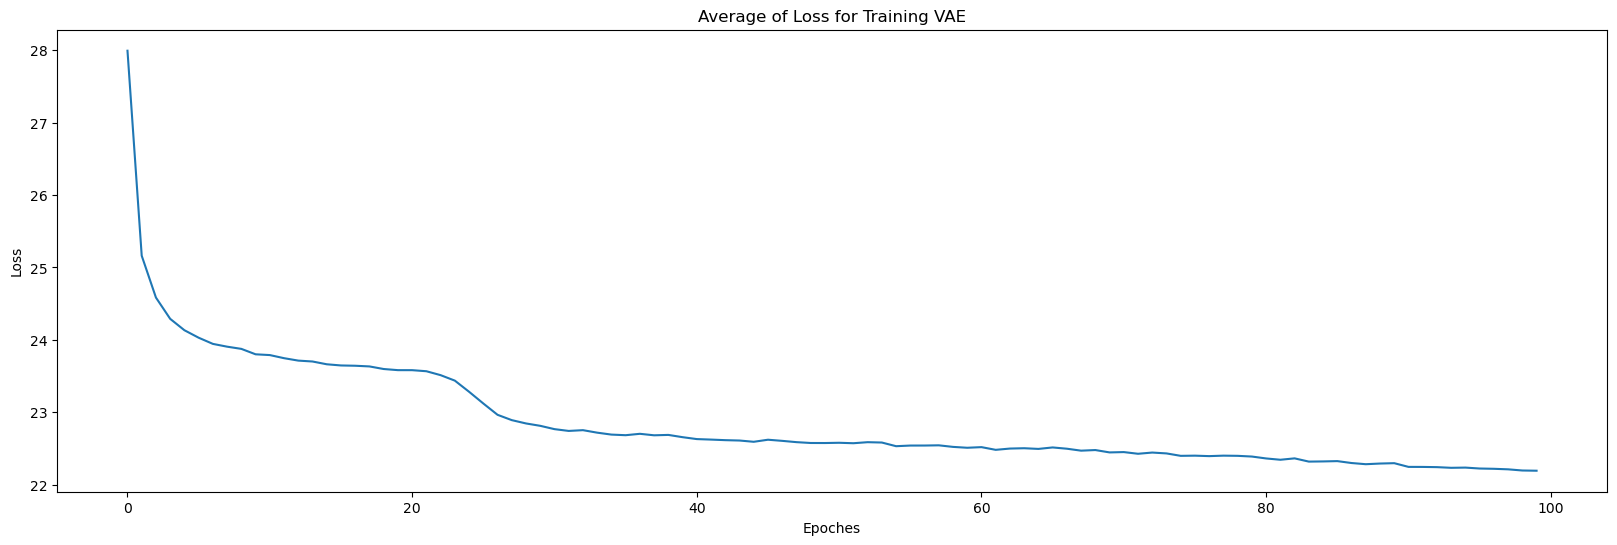

In [23]:
plot_losses(average_loss)

#### **10. Compute the Reconstruction Probability**

In [24]:
vae.eval()

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=29, out_features=15, bias=True)
    (fc2): Linear(in_features=15, out_features=8, bias=True)
    (mean_layer): Linear(in_features=8, out_features=2, bias=True)
    (logvar_layer): Linear(in_features=8, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=15, bias=True)
    (fc3): Linear(in_features=15, out_features=29, bias=True)
  )
)

In [25]:
reconstruction_loss_ave = []

for x_test in tqdm(X_test):

    reconstruction_loss_all = 0

    for _ in range(20):
        
        x_test_reconstruct, mean, logvar = vae.forward(x_test)
        reconstruction_loss_all += F.mse_loss(x_test_reconstruct, x_test, reduction='sum')
    
    reconstruction_loss_ave.append(reconstruction_loss_all/20)

100%|██████████| 71202/71202 [04:53<00:00, 242.32it/s]


#### **11. Make the Dataframe with Recon Errors and True Labels**

In [26]:
reconstruction_loss_ave = [tensor.item() for tensor in reconstruction_loss_ave]

In [27]:
test_result = y_test.to_frame()
test_result['Reconstruction Error'] = reconstruction_loss_ave

test_result

,Class,Reconstruction Error
80071,0,8.572254
263377,0,28.581781
274895,0,35.684677
214117,0,13.866316
169156,0,15.395691
...,...,...
68055,0,19.009470
64709,0,63.569519
85960,0,8.964423
167375,0,9.417203


#### **12. Plot the Histograms of the Recon Errors**

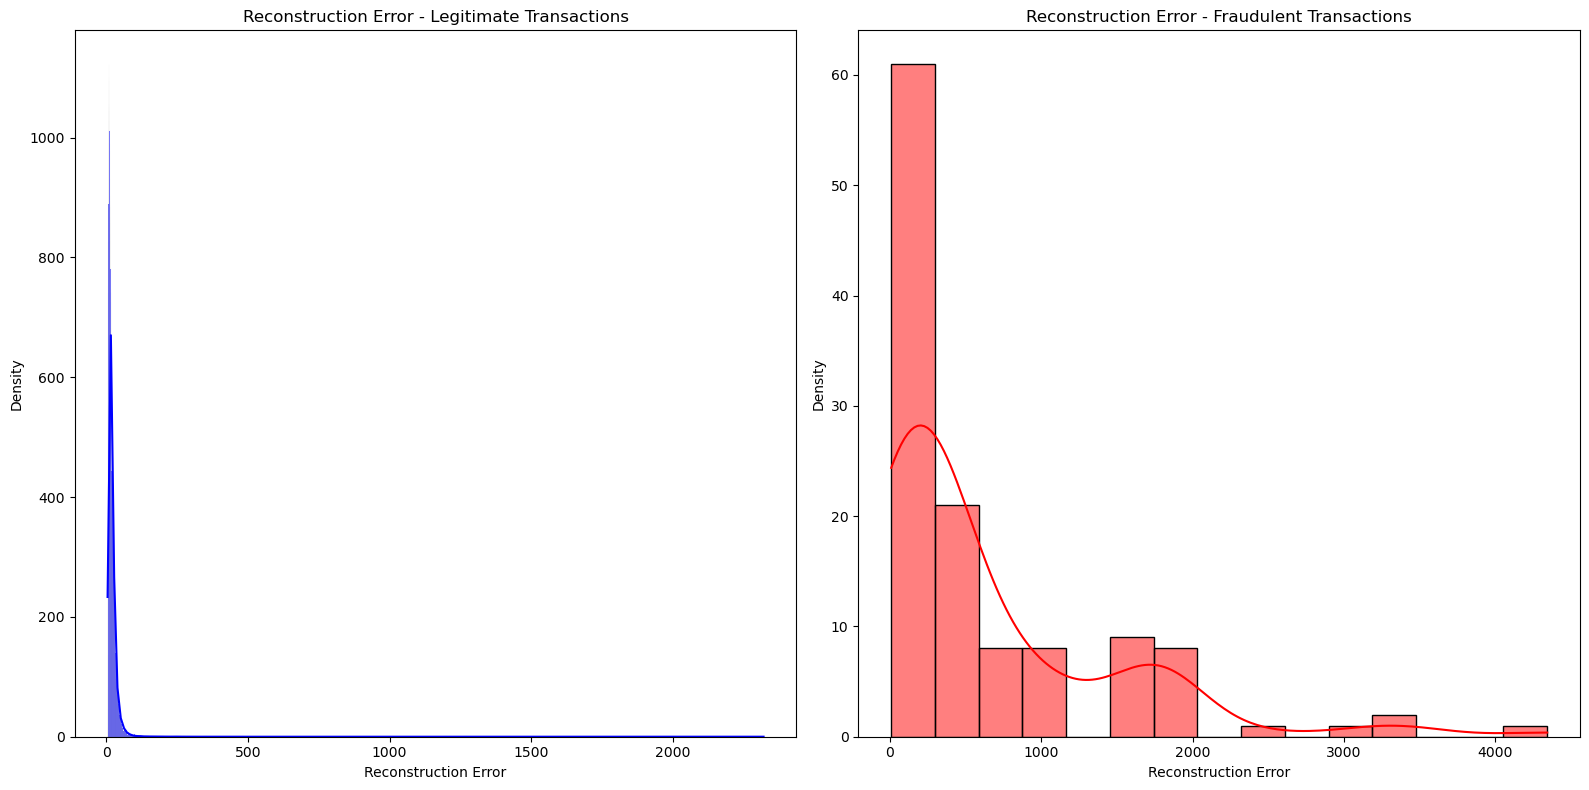

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

legitimate_errors = test_result[test_result['Class'] == 0]['Reconstruction Error']
fraudulent_errors = test_result[test_result['Class'] == 1]['Reconstruction Error']

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.histplot(legitimate_errors, bins = 10000, kde=True, color='blue')
plt.title('Reconstruction Error - Legitimate Transactions')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
sns.histplot(fraudulent_errors, kde=True, color='red')
plt.title('Reconstruction Error - Fraudulent Transactions')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

According to the above histograms, we could tell that the reconstruction error between samples from legitimate and fraudulent transactions are very different. To make the classification, we set a threshold recon error λ to be 200.

In [39]:
lambda_ = 200

#### **13. Compute the Confusion Matrix**

After determining the threshold, we could make predictions by classifying the samples. If recon error < λ, the prediction will be legit (0), else fraud (1).

Since it's a binary classification problem, we could compute the **confusion matrix** after prediction. In binary classification problems, there are four combinations of the ground-truth class and the predicted class, namely true positive, false positive, true negative, and false negative, and TP + FP + TN + FN = total number of samples.

The following plot is from Machine Learning by Zhi-Hua Zhou, shows a confusion matrix.

Based on the confusion matrix, we could compute **precision** and **recall** accordingly:

Precision = TP/(TP+FP) &nbsp; Recall = TP/(TP+FN)

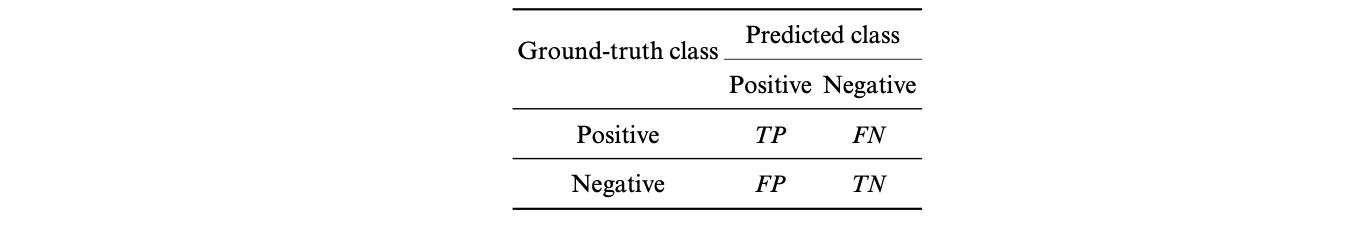

In [42]:
def predict_fraud(df, lambda_):

    df['Class_predict'] = df['Reconstruction Error'].apply(lambda x: 1 if x >= lambda_ else 0)

    return df

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score

def get_confusion_matrix(df_predict):

    actual_classes = df_predict['Class']
    predicted_classes = df_predict['Class_predict']

    conf_matrix = confusion_matrix(actual_classes, predicted_classes)

    precision = precision_score(actual_classes, predicted_classes)
    recall = recall_score(actual_classes, predicted_classes)
    accuracy = accuracy_score(actual_classes, predicted_classes)

    return conf_matrix, precision, recall, accuracy

In [53]:
df_predict = predict_fraud(test_result, lambda_ = 200)
df_predict.head()

,Class,Reconstruction Error,Class_predict
80071,0,8.572254,0
263377,0,28.581781,0
274895,0,35.684677,0
214117,0,13.866316,0
169156,0,15.395691,0


In [54]:
conf_matrix, precision, recall, accuracy = get_confusion_matrix(df_predict)

print("Confusion Matrix: ")
print(conf_matrix)
print(" ")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Confusion Matrix: 
[[70960   122]
 [   47    73]]
 
Accuracy: 0.9976
Precision: 0.3744
Recall: 0.6083


According to the above result, when setting recon error threshold λ = 200, among all test samples, there were 70960 samples where the model predicted as the legit class were actually legit (true label = 0, predict label = 0), and there were 73 samples where the model predicted as the fraud class were actually fraud (true label = 1, predict label = 1). However, the model made wrong predictions on 47 fraud cases (true label = 1, predict label = 0) and 122 legit cases (true label = 0, predict label = 1).

And we could calculate the metrics, and find precision to be 37.44%, recall to be 60.83%.

#### **14. Try Different Threshold Values**

* **λ = 100**

In [57]:
df_predict = predict_fraud(test_result, lambda_ = 100)

conf_matrix, precision, recall, accuracy = get_confusion_matrix(df_predict)

print("Confusion Matrix: ")
print(conf_matrix)
print(" ")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Confusion Matrix: 
[[70705   377]
 [   26    94]]
 
Accuracy: 0.9943
Precision: 0.1996
Recall: 0.7833


* **λ = 200**

In [58]:
df_predict = predict_fraud(test_result, lambda_ = 200)

conf_matrix, precision, recall, accuracy = get_confusion_matrix(df_predict)

print("Confusion Matrix: ")
print(conf_matrix)
print(" ")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Confusion Matrix: 
[[70960   122]
 [   47    73]]
 
Accuracy: 0.9976
Precision: 0.3744
Recall: 0.6083


* **λ = 300**

In [59]:
df_predict = predict_fraud(test_result, lambda_ = 300)

conf_matrix, precision, recall, accuracy = get_confusion_matrix(df_predict)

print("Confusion Matrix: ")
print(conf_matrix)
print(" ")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Confusion Matrix: 
[[71025    57]
 [   62    58]]
 
Accuracy: 0.9983
Precision: 0.5043
Recall: 0.4833


As recon error threshold gets larger, in the confusion matrix, TP and FP get larger, FN and TN get smaller. Accordingly, precision becomes larger, and recall goes down.

#### **15. See How the Threshold Divides the Data**

<Figure size 1600x800 with 0 Axes>

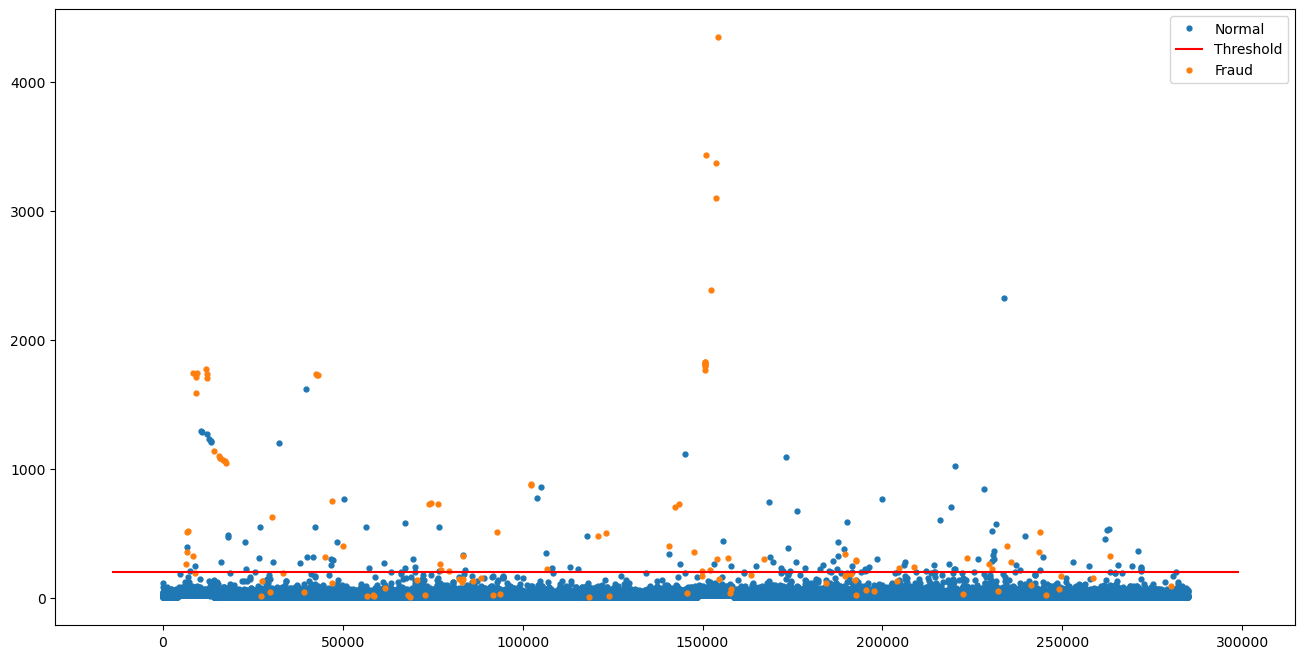

In [74]:
threshold = 200

plt.figure(figsize=(16, 8)) 

groups = df_predict.groupby('Class')
fig, ax = plt.subplots(figsize=(16, 8))  

for name, group in groups:
    ax.plot(group.index, group['Reconstruction Error'], marker='o', ms=3.5, linestyle='', label='Fraud' if name == 1 else 'Normal')

    if name == 0:
        ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', zorder=100, label='Threshold')

    ax.legend()

plt.show()